In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/admyyh/miniconda3/envs/ultralytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Hyperparameters
batch_size = 128
vqvae_epochs = 20
prior_epochs = 15
learning_rate = 1e-3
embedding_dim = 64  # Dimension of the codebook vectors
num_embeddings = 512  # Number of vectors in the codebook
beta = 0.25  # Commitment loss weight
hidden_dim = 512  # Hidden dimension for RNN
num_layers = 2  # Number of RNN layers
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [4]:
# Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Vector Quantizer Layer
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta
        
        # Initialize embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)
    
    def forward(self, z):
        # z shape: (batch, embedding_dim, height, width)
        # Reshape z for easier calculations
        z_flattened = z.permute(0, 2, 3, 1).contiguous()  # (batch, height, width, embedding_dim)
        flat_z = z_flattened.view(-1, self.embedding_dim)  # (batch*height*width, embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_z**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_z, self.embedding.weight.t()))
                    
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # (batch*height*width, 1)
        
        # Convert encodings to one-hot
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize the latents
        quantized = torch.matmul(encodings, self.embedding.weight).view(z_flattened.size())
        
        # Compute the VQ Losses
        # Commitment loss
        q_latent_loss = F.mse_loss(quantized.detach(), z_flattened)
        # Codebook loss
        e_latent_loss = F.mse_loss(quantized, z_flattened.detach())
        # Total loss
        loss = q_latent_loss + self.beta * e_latent_loss
        
        # Preserve gradients
        quantized = z_flattened + (quantized - z_flattened).detach()
        
        # Return values
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, encoding_indices.view(z.size(0), -1)


In [6]:
# VQVAE Model
class VQVAE(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, beta):
        super(VQVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, embedding_dim, kernel_size=1, stride=1)
        )
        
        # Vector Quantizer
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, beta)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def quantize(self, z):
        quantized, vq_loss, indices = self.vq(z)
        return quantized, vq_loss, indices
    
    def decode(self, quantized):
        x_recon = self.decoder(quantized)
        return x_recon
    
    def forward(self, x):
        z = self.encode(x)
        quantized, vq_loss, indices = self.quantize(z)
        x_recon = self.decode(quantized)
        return x_recon, vq_loss, indices
    
    def encode_indices(self, x):
        """
        Encode input images to discrete indices
        """
        z = self.encode(x)
        _, _, indices = self.quantize(z)
        return indices
    
    def decode_indices(self, indices, h=7, w=7):
        """
        Decode from discrete indices to images
        """
        batch_size = indices.size(0)
        
        # Convert indices to one-hot encodings
        encodings = torch.zeros(batch_size*h*w, self.vq.num_embeddings, device=indices.device)
        encodings.scatter_(1, indices.reshape(-1, 1), 1)
        
        # Convert one-hot to embeddings
        quantized = torch.matmul(encodings, self.vq.embedding.weight)
        quantized = quantized.view(batch_size, h, w, self.vq.embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        # Decode
        x_recon = self.decode(quantized)
        return x_recon


In [7]:
# Autoregressive Prior Model (using RNN)
class AutoregressivePrior(nn.Module):
    def __init__(self, num_embeddings, hidden_dim, num_layers, latent_size=49):  # 7x7=49
        super(AutoregressivePrior, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_embeddings)
        
        self.num_embeddings = num_embeddings
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.latent_size = latent_size
        
    def forward(self, indices):
        """
        Input: indices of shape [batch_size, seq_len]
        Output: logits for next index prediction [batch_size, seq_len, num_embeddings]
        """
        # Shift indices for teacher forcing (prepend start token)
        batch_size = indices.size(0)
        start_tokens = torch.zeros(batch_size, 1, dtype=torch.long, device=indices.device)
        
        # Teacher forcing input (all but last token)
        teacher_input = torch.cat([start_tokens, indices[:, :-1]], dim=1)
        
        # Embed the indices
        embedded = self.embedding(teacher_input)
        
        # Pass through GRU
        output, _ = self.gru(embedded)
        
        # Project to vocabulary size
        logits = self.fc(output)
        
        return logits
    
    def sample(self, batch_size=1, temperature=1.0):
        """
        Sample a batch of latent codes from the prior model
        """
        device = next(self.parameters()).device
        
        # Start with all zeros (start tokens)
        current_indices = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        
        # Initialize hidden state
        hidden = None
        
        # Generate each position autoregressively
        generated_indices = []
        
        for _ in range(self.latent_size):
            # Embed current indices
            embedded = self.embedding(current_indices)
            
            # Get prediction from GRU
            output, hidden = self.gru(embedded, hidden)
            
            # Get logits for next position
            logits = self.fc(output[:, -1:, :]) / temperature
            
            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            next_indices = torch.multinomial(probs.squeeze(1), 1)
            
            # Add to generated indices
            generated_indices.append(next_indices)
            
            # Update current indices for next iteration
            current_indices = next_indices
        
        # Stack all generated indices
        sampled_indices = torch.cat(generated_indices, dim=1)
        
        return sampled_indices


In [8]:
# Loss function for VQVAE
def vqvae_loss_function(recon_x, x, vq_loss):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x)
    
    # Total loss
    total_loss = recon_loss + vq_loss
    
    return total_loss


In [9]:
# Create models
vqvae_model = VQVAE(embedding_dim, num_embeddings, beta).to(device)
prior_model = AutoregressivePrior(num_embeddings, hidden_dim, num_layers).to(device)

In [10]:
# Optimizers
vqvae_optimizer = optim.Adam(vqvae_model.parameters(), lr=learning_rate)
prior_optimizer = optim.Adam(prior_model.parameters(), lr=learning_rate)

In [ ]:
# Stage 1: Train the VQVAE
print("Training VQ-VAE...")
vqvae_train_losses = []

for epoch in range(1, vqvae_epochs + 1):
    vqvae_model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        vqvae_optimizer.zero_grad()
        
        recon_batch, vq_loss, _ = vqvae_model(data)
        loss = vqvae_loss_function(recon_batch, data, vq_loss)
        
        loss.backward()
        vqvae_optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'VQ-VAE Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    vqvae_train_losses.append(avg_loss)
    print(f'====> VQ-VAE Epoch: {epoch} Average loss: {avg_loss:.4f}')


Training VQ-VAE...


VQ-VAE Train Epoch: 1 [0/60000 (0%)]	Loss: 0.003951
VQ-VAE Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001444
VQ-VAE Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000537
VQ-VAE Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000334
VQ-VAE Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000270
====> VQ-VAE Epoch: 1 Average loss: 0.0013
VQ-VAE Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000233
VQ-VAE Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000196
VQ-VAE Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000173
VQ-VAE Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000156
VQ-VAE Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000146
====> VQ-VAE Epoch: 2 Average loss: 0.0002
VQ-VAE Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000138
VQ-VAE Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000132
VQ-VAE Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000122
VQ-VAE Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000126
VQ-VAE Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000114
====> VQ-VAE Epoch: 3 Average loss: 0.0001
VQ-VAE Train Epoch: 4 [0/60000 

In [12]:
# Save the trained VQVAE model
torch.save(vqvae_model.state_dict(), 'vqvae_mnist.pth')

# %%
# Extract latent indices from the dataset for training the prior
print("Extracting latent codes...")
vqvae_model.eval()
all_indices = []

with torch.no_grad():
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        indices = vqvae_model.encode_indices(data)
        all_indices.append(indices.cpu())

# Concatenate all indices
all_indices = torch.cat(all_indices, dim=0)

# Create a new DataLoader for the indices
indices_dataset = torch.utils.data.TensorDataset(all_indices)
indices_loader = torch.utils.data.DataLoader(
    indices_dataset, batch_size=batch_size, shuffle=True
)

Extracting latent codes...


100%|██████████| 469/469 [00:04<00:00, 97.75it/s] 


In [ ]:
# Stage 2: Train the Autoregressive Prior
print("Training Autoregressive Prior...")
prior_train_losses = []

for epoch in range(1, prior_epochs + 1):
    prior_model.train()
    train_loss = 0
    
    for batch_idx, (indices,) in enumerate(indices_loader):
        indices = indices.to(device)
        prior_optimizer.zero_grad()
        
        # Forward pass
        logits = prior_model(indices)
        
        # Cross entropy loss (target is original indices)
        loss = F.cross_entropy(logits.reshape(-1, num_embeddings), indices.reshape(-1))
        
        loss.backward()
        prior_optimizer.step()
        
        train_loss += loss.item() * indices.size(0)
        
        if batch_idx % 100 == 0:
            print(f'Prior Train Epoch: {epoch} [{batch_idx * len(indices)}/{len(indices_loader.dataset)} '
                  f'({100. * batch_idx / len(indices_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = train_loss / len(indices_loader.dataset)
    prior_train_losses.append(avg_loss)
    print(f'====> Prior Epoch: {epoch} Average loss: {avg_loss:.4f}')


Training Autoregressive Prior...


Prior Train Epoch: 1 [0/60000 (0%)]	Loss: 0.920725
Prior Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.922458
Prior Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.919712
Prior Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.897300
Prior Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.929575
====> Prior Epoch: 1 Average loss: 0.9476
Prior Train Epoch: 2 [0/60000 (0%)]	Loss: 0.933248
Prior Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.926541
Prior Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.943818


In [14]:
# Save the trained prior model
torch.save(prior_model.state_dict(), 'prior_mnist.pth')

# %%
# Evaluate the VQVAE
vqvae_model.eval()
test_loss = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon_batch, vq_loss, _ = vqvae_model(data)
        test_loss += vqvae_loss_function(recon_batch, data, vq_loss).item()

test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')


====> Test set loss: 0.0001


Generating samples...


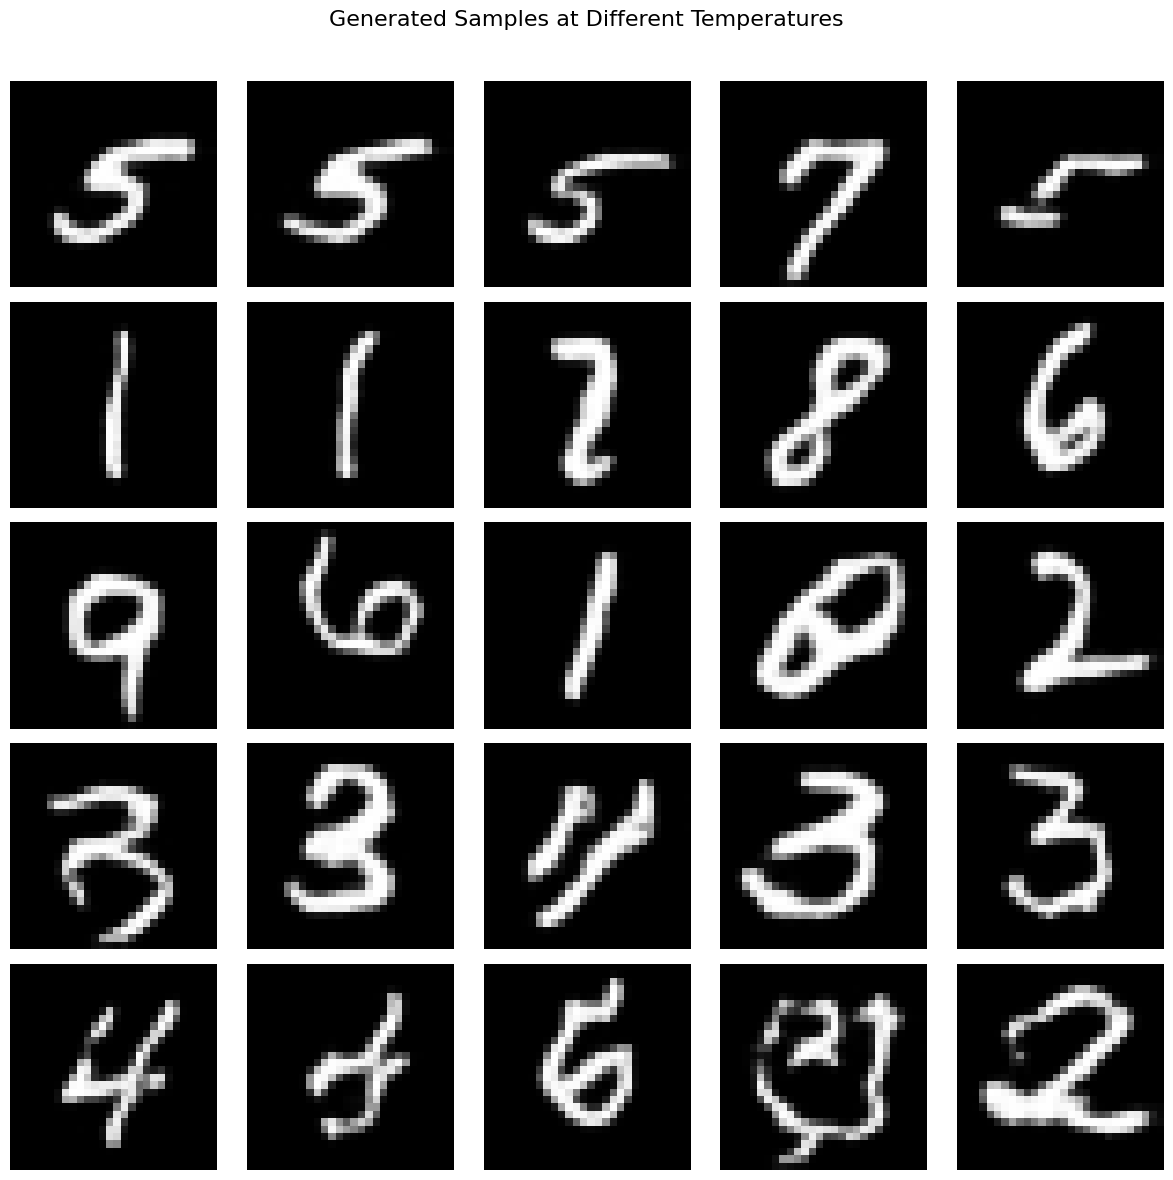

In [18]:
# Generate samples using the full model
print("Generating samples...")
num_samples = 25
temperatures = [0.5, 0.75, 1.0, 1.25, 1.5]

# Generate samples at different temperatures
all_samples = []

with torch.no_grad():
    prior_model.eval()
    vqvae_model.eval()
    
    for temp in temperatures:
        # Sample latent codes from the prior
        sampled_indices = prior_model.sample(batch_size=5, temperature=temp)
        
        # Decode to images
        samples = vqvae_model.decode_indices(sampled_indices)
        all_samples.append(samples.cpu())

# Plot samples
fig, axes = plt.subplots(len(temperatures), 5, figsize=(12, 12))
fig.suptitle('Generated Samples at Different Temperatures', fontsize=16)

for i, temp in enumerate(temperatures):
    for j in range(5):
        ax = axes[i, j]
        ax.imshow(all_samples[i][j, 0], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'T={temp}', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

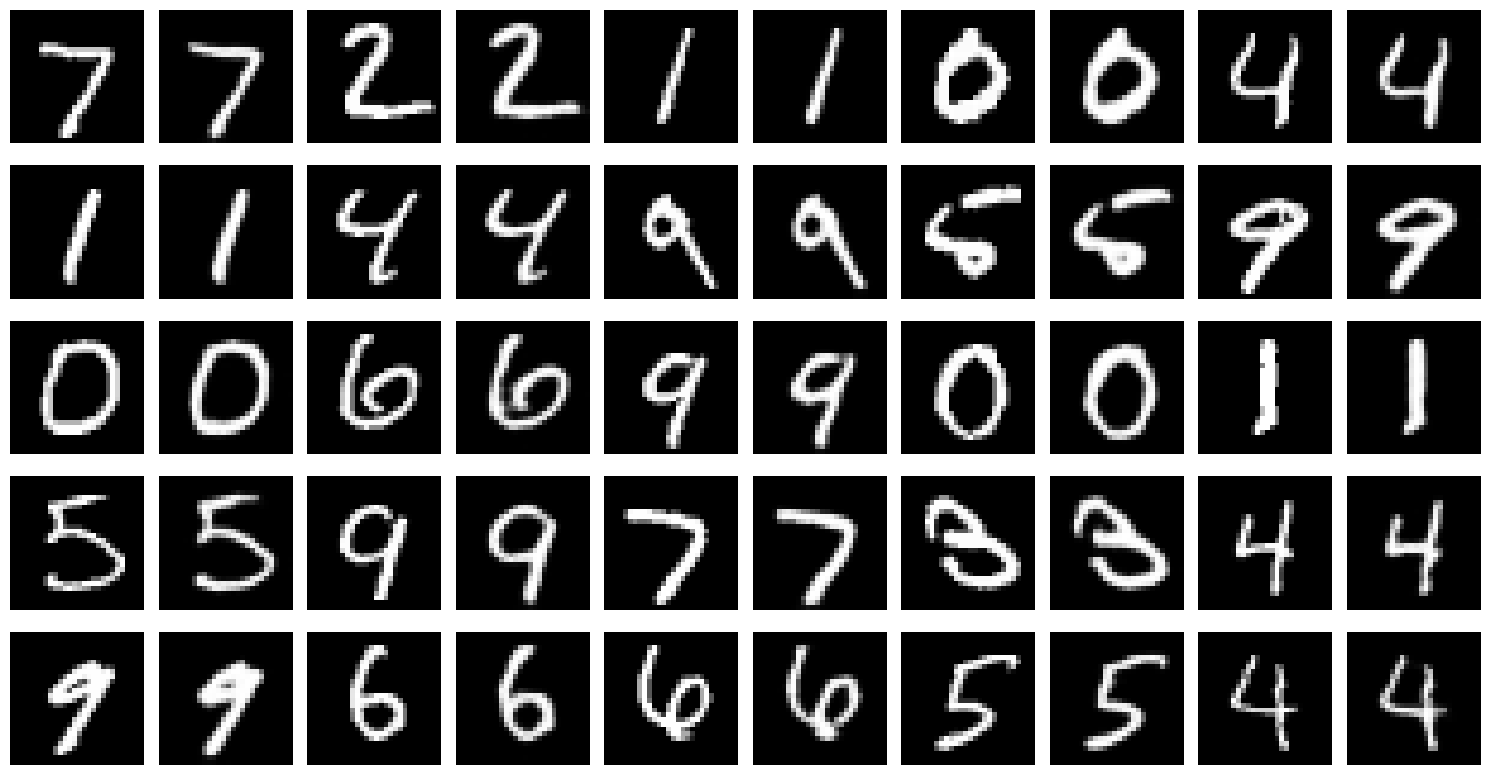

In [16]:
# Visualize reconstructions
with torch.no_grad():
    # Get a batch of test data
    data, _ = next(iter(test_loader))
    data = data[:25].to(device)
    
    # Reconstruct
    recon_batch, _, _ = vqvae_model(data)
    
    # Plot original vs reconstructions
    fig, axes = plt.subplots(5, 10, figsize=(15, 8))
    
    for i in range(25):
        # Original
        ax = axes[i//5, (i%5)*2]
        ax.imshow(data[i][0].cpu(), cmap='gray')
        ax.axis('off')
        
        # Reconstruction
        ax = axes[i//5, (i%5)*2 + 1]
        ax.imshow(recon_batch[i][0].cpu(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('vqvae_prior_reconstructions.png')
    plt.show()


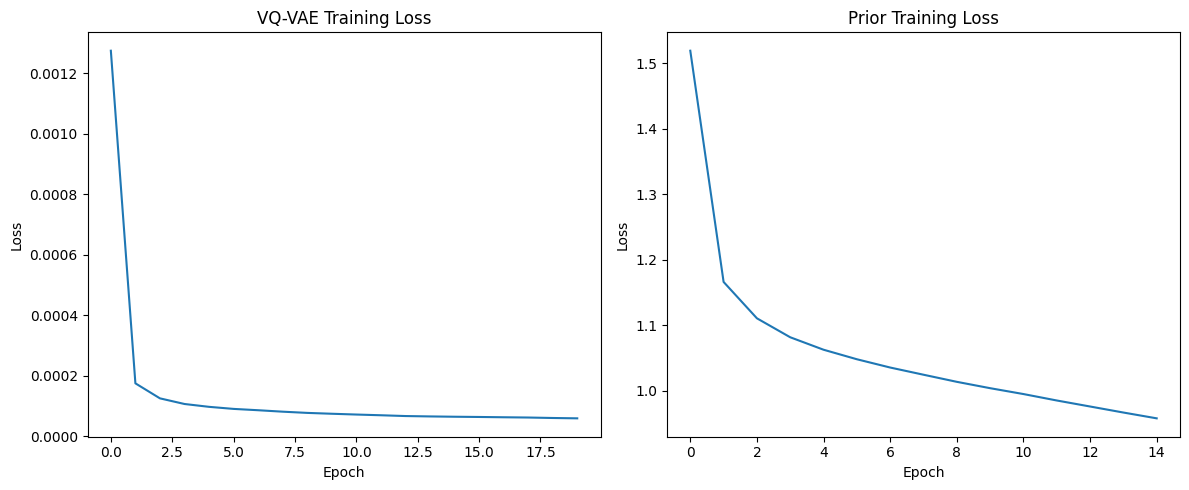

In [17]:
# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vqvae_train_losses)
plt.title('VQ-VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(prior_train_losses)
plt.title('Prior Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('vqvae_prior_training_losses.png')
plt.show()